In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import AEMpy library
import aempy

# Import Extra libraries
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, datetime
import seaborn as sns

In [3]:
system = aempy.System()

In [4]:
# Request error logs
errorlogs = system.log_error()

Request: http://localhost:4502/system/console/slinglog/tailer.txt?tail=10000&grep=*&name=/logs/error.log


In [5]:
# There is a builtin parsing in AEMpy to automatically convert logs to pandas dataframe
dfErrors = system.log_to_dataframe(errorlogs)

In [6]:
# What is the distribution of the message levels?
dfErrors.groupby("level")["level"].count()

level
ERROR     344
INFO     9545
WARN       46
Name: level, dtype: int64

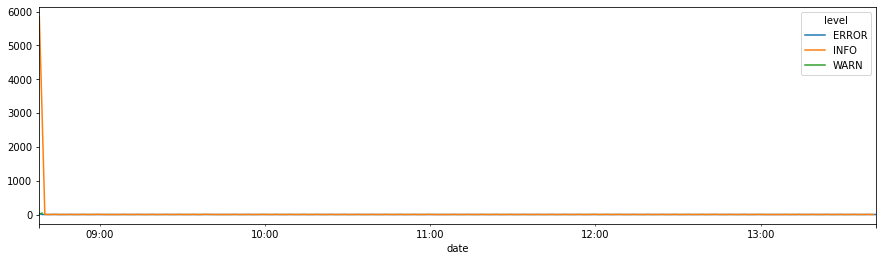

In [7]:
# Plot the messages with 1 min frequency
system.plot(dfErrors)

In [8]:
# Read a local log file
dfErrors = system.logfile_to_dataframe("error.log.2020-07-29")

In [9]:
# What is the distribution of the message levels?
dfErrors.groupby("level")["level"].count()

level
ERROR    1248
INFO     6308
WARN     2444
Name: level, dtype: int64

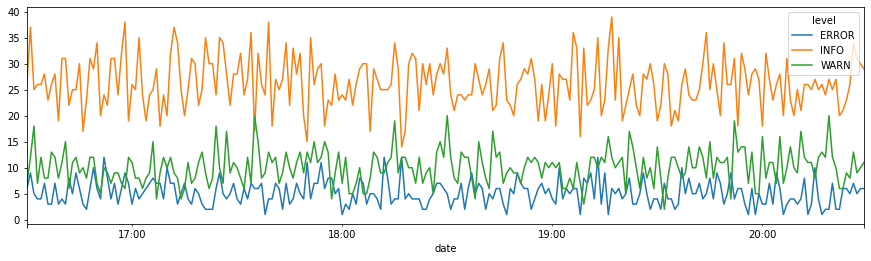

In [10]:
# Plot the messages with 1 min frequency
system.plot(dfErrors)

In [11]:
# Filter to keep only errors
df_ERROR = dfErrors[dfErrors["level"] == "ERROR"]

In [30]:
df_ERROR

,date,level,class,message
6,2020-07-29 16:30:16,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
9,2020-07-29 16:30:18,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
12,2020-07-29 16:30:25,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
17,2020-07-29 16:30:29,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
19,2020-07-29 16:30:35,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
...,...,...,...,...
9986,2020-07-29 20:29:46,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
9987,2020-07-29 20:29:47,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
9990,2020-07-29 20:29:48,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."
9991,2020-07-29 20:29:52,ERROR,sling-threadpool-67387070-8373-45bd-bead-d6282...,"[com.day.cq.replication.impl.AgentManagerImpl,..."


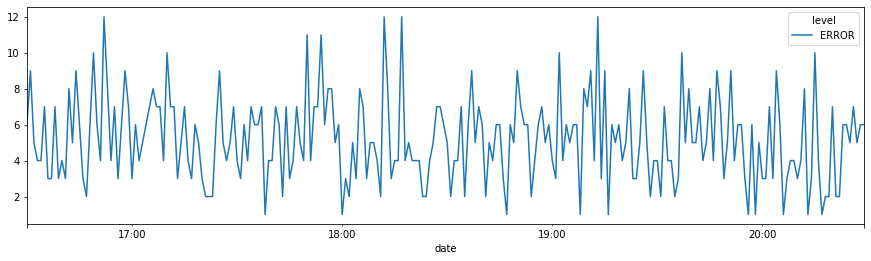

In [18]:
# Plot the ERROR messages with 1 min frequency
# See available frequencies here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
system.plot(df_ERROR, "1min") # "1ms")

In [34]:
t = (df_ERROR.assign(counter = 1)
             .set_index('date')
             .groupby([pd.Grouper(freq="1min"), 'level']).sum()
             .squeeze()
             .unstack())

In [35]:
t

level,ERROR
date,
2020-07-29 16:30:00,6
2020-07-29 16:31:00,9
2020-07-29 16:32:00,5
2020-07-29 16:33:00,4
2020-07-29 16:34:00,4
...,...
2020-07-29 20:25:00,5
2020-07-29 20:26:00,7
2020-07-29 20:27:00,5


In [36]:
n = len(t)
train_df = t[0:int(n*0.7)]
val_df = t[int(n*0.7):int(n*0.9)]
test_df = t[int(n*0.9):]


In [39]:
train_mean = t.mean()
train_std = t.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

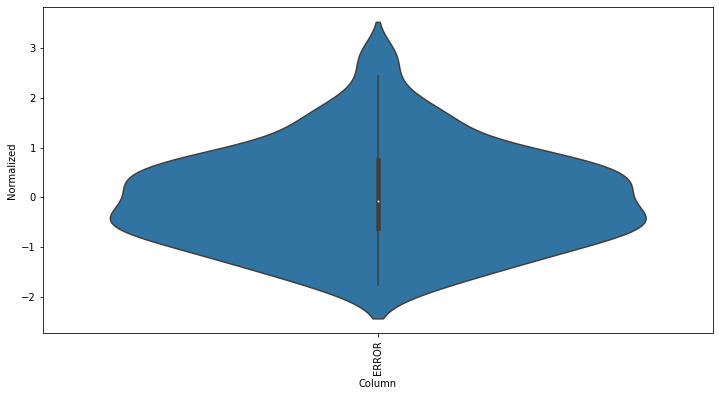

In [42]:
df_std = (t - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(t.keys(), rotation=90)


In [43]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
